# Smoothing filters

## Import libraries

To install libraries in Python, you can use a package manager like pip, which comes pre-installed with most Python distributions.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd 
from scipy import signal

In [4]:
data = pd.read_excel('datasets/dataset.xlsx')
data

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3
...,...,...,...,...,...,...,...,...
7115,23896.6,3893.1,37567.5,38276.6,11183.1,4515.5,31611.9,48532.8
7116,23850.2,3780.5,37514.3,38075.4,11119.7,4572.2,31551.9,48566.2
7117,23766.2,3644.2,37432.3,37477.1,11029.8,4755.0,31464.2,47165.5
7118,23768.4,3709.8,37443.6,37362.9,11048.4,4738.0,31481.5,46410.0


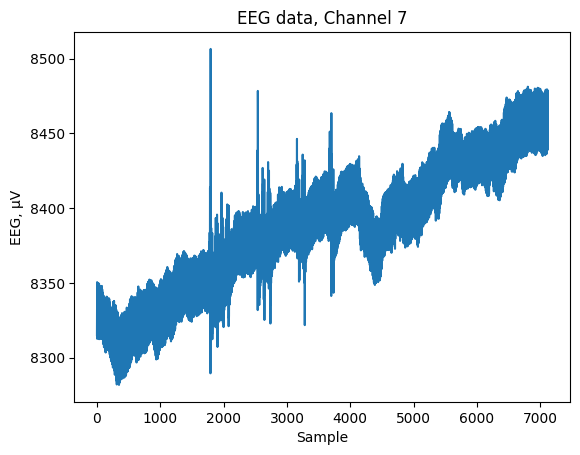

In [5]:
# select the data from the seventh channel
channel = 6
channel_data = data.iloc[:, channel]
channel_data = round(1000000*4.5*(channel_data/16777215),2)  # Convert data from ADC to µV

# plot the EEG data
plt.plot(channel_data)
plt.title("EEG data, Channel " + str(channel+1))
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

## Band Pass Filter

Band-pass filtering is a common signal processing technique used in EEG (Electroencephalography) data analysis to isolate specific frequency bands of interest while removing unwanted frequencies. Band-pass filtering allows researchers to focus on particular brainwave rhythms that are relevant to their study. For example, you might want to extract the alpha, beta, or gamma waves from the EEG data.

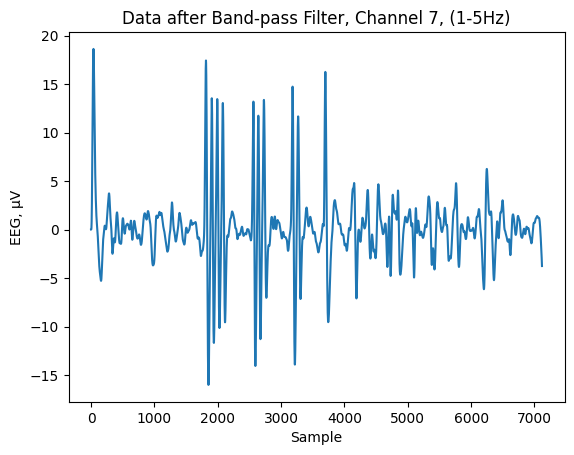

In [6]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

channel_data_bp_filtered = channel_data.copy()  # copy the data
fps = 250  # sampling frequency
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 5  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency)

# apply the band-pass filter
channel_data_bp_filtered = butter_highpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_high,
    nyq=nyq,
    order=5)
channel_data_bp_filtered = butter_lowpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_low,
    nyq=nyq,
    order=4)

plt.plot(channel_data_bp_filtered)
plt.title("Data after Band-pass Filter, Channel " +  str(channel+1) +", ("+str(cutoff_high)+"-"+str(cutoff_low) + "Hz)")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

## Smoothing filters

Smoothing filters are essential tools in EEG signal processing, used to reduce noise and highlight underlying patterns. These filters work by averaging or weighting neighboring data points to create a smoother representation of the signal. The average filter computes the mean of nearby samples, reducing high-frequency noise.

## Average filter

In signal processing of EEG (Electroencephalography) data, calculating the average is a common technique used to improve the signal-to-noise ratio and highlight underlying brain activity. The EEG signal is often contaminated with noise and artifacts, and averaging can help reduce these unwanted components while preserving the brain-related activity.   

**Positive**  

* An average filter can effectively smooth out the EEG signal by removing high-frequency noise and minor fluctuations.
* Easy to implement
* EEG signals often exhibit slow oscillatory patterns, such as alpha, beta, and delta waves. Applying an average filter with a longer time window can help visualize these slower frequency components by attenuating faster fluctuations

**Negative**

* Temporal Resolution. Applying an average filter with a large window can smooth out fine temporal details and fast changes in the EEG signal. Depending on your analysis goals, this may or may not be desirable.

* Signal Distortion. Over-smoothing can lead to the loss of important signal features, including transient responses or rapid changes that might be critical for your analysis.

* Baseline Fluctuations. If analysis involves comparing EEG activity before and after specific events, excessive smoothing can reduce the detectable differences in baseline fluctuations.

**How it works**  

An average filter for EEG works by smoothing out the signal by replacing each data point with the average value of neighboring data points within a defined window. Need to choose an appropriate window size to balance noise reduction with preserving important signal features.

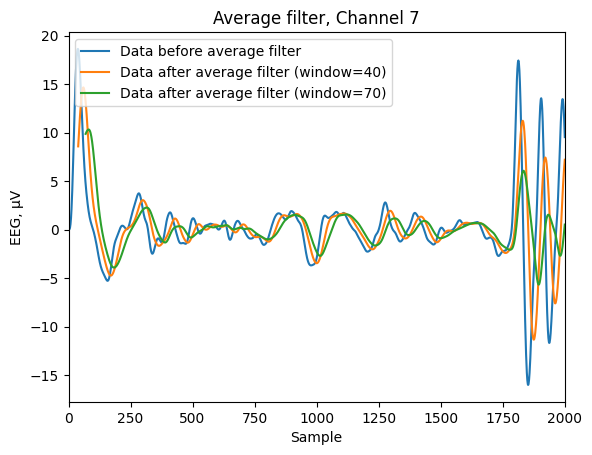

In [7]:
def average_filter(data, average_length):
    """Average filter.
    Args:
        data (array_like): data to be filtered.
        average_length (int): length of the filter window.
    Returns:
        array: filtered data."""
    data = pd.DataFrame(data)
    avereged_data = data.rolling(window=average_length).mean()
    return avereged_data

# you can control the "smoothness" of the data by changing the window size
average_length_window_1 = 40
average_length_window_2 = 70

channel_data_avg_window_1 = average_filter(data=channel_data_bp_filtered, average_length=average_length_window_1)
channel_data_avg_window_2 = average_filter(data=channel_data_bp_filtered, average_length=average_length_window_2)

plt.title("Average filter, Channel " +  str(channel+1))
plt.plot(channel_data_bp_filtered, label='Data before average filter')
plt.plot(channel_data_avg_window_1, label='Data after average filter (window='+str(average_length_window_1)+")")
plt.plot(channel_data_avg_window_2, label='Data after average filter (window='+str(average_length_window_2)+")")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.legend(loc='upper left')
plt.xlim([0, 2000])  # zoom in the data
plt.show()